In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
from dotenv import load_dotenv
from census import Census
from itertools import chain 
from matplotlib import pyplot as plt

In [3]:
load_dotenv()
api_key = os.getenv('api_key')

# Load Census Data

In [4]:
# load relationship files
df_tract_rel = pd.read_csv('https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt', sep='|')
df_block_rel = pd.read_csv("tab2010_tab2020_st36_ny.txt")

In [5]:
nyc_tracts = gpd.read_file("https://data.cityofnewyork.us/resource/63ge-mke6.geojson?$limit=100000")
#nyc_tracts = gpd.read_file("2020 Census Tracts_20250307.geojson")
nyc_tracts.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,geometry
0,1843004.52241,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),10833.0439286,Manhattan,000100,MN0191,1,None,36061000100,1000100,MN01,1,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,1006116.58429,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5075.33199978,Manhattan,001401,MN0302,1,None,36061001401,1001401,MN03,14.01,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ..."
2,1226206.24719,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4459.1560187,Manhattan,001402,MN0302,1,None,36061001402,1001402,MN03,14.02,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ..."
3,2399276.86435,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),6391.92117449,Manhattan,001800,MN0302,1,None,36061001800,1001800,MN03,18,"MULTIPOLYGON (((-73.98985 40.72052, -73.98972 ..."
4,1740173.87581,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5779.06260724,Manhattan,002201,MN0302,1,None,36061002201,1002201,MN03,22.01,"MULTIPOLYGON (((-73.97875 40.71993, -73.97879 ..."


In [6]:
# load 2010 tracts
nyc_tracts_2010 = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_36061_tract10.zip")
nyc_tracts_2010.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,061,027100,36061027100,271,Census Tract 271,G5020,S,192555,0,+40.8519392,-073.9342905,"POLYGON ((-73.93666 40.85045, -73.93634 40.851..."
1,36,061,012900,36061012900,129,Census Tract 129,G5020,S,404996,407508,+40.7650139,-073.9998117,"POLYGON ((-74.00827 40.76485, -74.00585 40.768..."
2,36,061,014401,36061014401,144.01,Census Tract 144.01,G5020,S,74319,0,+40.7752486,-073.9475520,"POLYGON ((-73.94937 40.77688, -73.94919 40.776..."
3,36,061,009900,36061009900,99,Census Tract 99,G5020,S,1007102,1125670,+40.7523775,-074.0083669,"POLYGON ((-73.99843 40.75556, -73.99866 40.755..."
4,36,061,014601,36061014601,146.01,Census Tract 146.01,G5020,S,74328,0,+40.7771918,-073.9521610,"POLYGON ((-73.94987 40.7762, -73.95034 40.7755..."


In [7]:
# select all tracts in the east village
cb3_sectors = {2020: {1: ['004200', '004002', '004001', '003602', '003800'],
2: ['003400', '003200', '003002'],
3: ['002800', '002602', '002601', '002202'],
4: ['003001', '002201'],
5: ['001200', '001001', '001402', '001401'],
6: ['000600', '000201', '000202'],
7: ['000800', '002700', '002500'],
8: ['002902', '001600'],
9: ['001800', '003601'],
10: ['002400', '002000', '001002']},
2010: {1: ['004200','004000', '003602', '003800'],
2: ['003400', '003200', '003002'],
3: ['002800', '002602', '002601', '002202'],
4: ['003001', '002201'],
5: ['001200', '001001', '001402', '001401'],
6: ['000600', '000201', '000202'],
7: ['000800', '002700', '002500'],
8: ['002900', '001600'],
9: ['001800', '003601'],
10: ['002400', '002000', '001002']},
}

cb3_tracts = list(chain.from_iterable(cb3_sectors[2020].values()))

In [8]:
# subset rel file to CB3
df_tract_rel['GEOID_form_20'] = df_tract_rel['GEOID_TRACT_20'].astype(str).str.pad(11, side='left', fillchar='0')
df_tract_rel['GEOID_form_10'] = df_tract_rel['GEOID_TRACT_10'].astype(str).str.pad(11, side='left', fillchar='0')
cb3_tract_rel = df_tract_rel[(df_tract_rel['GEOID_form_20'].str.slice(-6).isin(cb3_tracts))&\
   (df_tract_rel['GEOID_form_20'].str.slice(0,5)=='36061') ]
cb3_tracts_2010 = cb3_tract_rel['GEOID_form_10'].str.slice(5).unique()

cb3_tracts_by_year = {
   2020: cb3_tracts,
   2010: cb3_tracts_2010
}

In [9]:
# check tracts that changed
cb3_tract_rel[cb3_tract_rel['GEOID_TRACT_20']!=cb3_tract_rel['GEOID_TRACT_10']]

,OID_TRACT_20,GEOID_TRACT_20,NAMELSAD_TRACT_20,AREALAND_TRACT_20,AREAWATER_TRACT_20,MTFCC_TRACT_20,FUNCSTAT_TRACT_20,OID_TRACT_10,GEOID_TRACT_10,NAMELSAD_TRACT_10,AREALAND_TRACT_10,AREAWATER_TRACT_10,MTFCC_TRACT_10,FUNCSTAT_TRACT_10,AREALAND_PART,AREAWATER_PART,GEOID_form_20,GEOID_form_10
77768,2079015681794567,36061002902,Census Tract 29.02,123830,0,G5020,S,20740460864031,36061002900,Census Tract 29,273358,0,G5020,S,123830,0,36061002902,36061002900
77780,2079019627440616,36061004001,Census Tract 40.01,91742,0,G5020,S,20740460873500,36061004000,Census Tract 40,178333,0,G5020,S,91742,0,36061004001,36061004000
77781,2079015681794515,36061004002,Census Tract 40.02,86591,0,G5020,S,20740460873500,36061004000,Census Tract 40,178333,0,G5020,S,86591,0,36061004002,36061004000


In [10]:
# create a gdf of just cb3
cb3_gdf = nyc_tracts[nyc_tracts['cdta2020'] == 'MN03'].copy()
print(cb3_gdf.shape[0], len(cb3_tracts))

31 31


In [11]:
# create a gdf of just cb3 for 2010
nyc_tracts_2010['ct2010'] = nyc_tracts_2010['GEOID10'].str.slice(5)
cb3_gdf_2010 = nyc_tracts_2010[nyc_tracts_2010['ct2010'].isin(cb3_tracts_by_year[2010])]
print(cb3_gdf_2010.shape[0], len(cb3_tracts_by_year[2010]))

30 30


In [12]:
cb3_gdf['sectors'] = np.select([cb3_gdf['ct2020'].isin(cb3_sectors[2020][i]) for i in cb3_sectors[2020].keys()], list(cb3_sectors[2020].keys()))
cb3_gdf.head()

cb3_gdf_2010['sectors'] = np.select([cb3_gdf_2010['ct2010'].isin(cb3_sectors[2010][i]) for i in cb3_sectors[2010].keys()], list(cb3_sectors[2010].keys()))
cb3_gdf_2010.head()

/opt/anaconda3/envs/cb3-census/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,ct2010,sectors
10,36,061,001401,36061001401,14.01,Census Tract 14.01,G5020,S,93510,0,+40.7151603,-073.9873314,"POLYGON ((-73.98608 40.7144, -73.98716 40.7143...",001401,5
34,36,061,000201,36061000201,2.01,Census Tract 2.01,G5020,S,90205,88971,+40.7098991,-073.9855836,"POLYGON ((-73.98455 40.7095, -73.98404 40.7048...",000201,6
83,36,061,002500,36061002500,25,Census Tract 25,G5020,S,133767,107616,+40.7085998,-073.9978104,"POLYGON ((-73.996 40.7089, -73.99365 40.7047, ...",002500,7
88,36,061,002202,36061002202,22.02,Census Tract 22.02,G5020,S,56090,0,+40.7212601,-073.9811422,"POLYGON ((-73.97875 40.71993, -73.97973 40.720...",002202,3
98,36,061,003400,36061003400,34,Census Tract 34,G5020,S,160257,0,+40.7290092,-073.9814618,"POLYGON ((-73.978 40.72943, -73.97854 40.72875...",003400,2


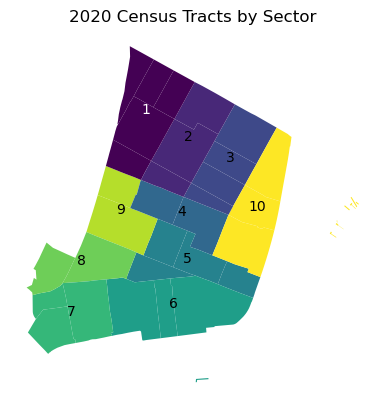

In [13]:
# create sector map
cb3_gdf = cb3_gdf.to_crs(2263)
cb3_gdf_diss = cb3_gdf.dissolve(by='sectors').to_crs(2263).reset_index()
cb3_gdf_diss['coords'] = cb3_gdf_diss['geometry'].centroid.apply(lambda x: x.coords[0])
ax = cb3_gdf.plot(column='sectors')
for idx, row in cb3_gdf_diss.iterrows():
    color='black'
    if row['sectors']==1:
        color='white'
    plt.annotate(text=row['sectors'], xy=row['coords'],
                 horizontalalignment='center', color=color)
plt.title('2020 Census Tracts by Sector')
ax.set_axis_off();

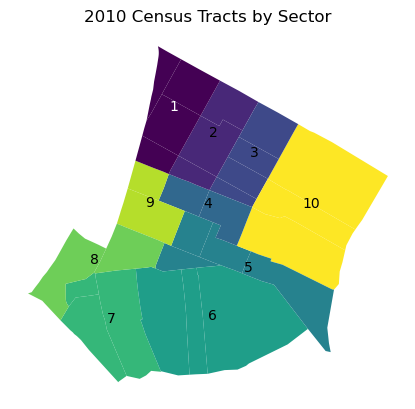

In [14]:
# create sector map
cb3_gdf_2010 = cb3_gdf_2010.to_crs(2263)
cb3_gdf_2010_diss = cb3_gdf_2010.dissolve(by='sectors').reset_index()
cb3_gdf_2010_diss['coords'] = cb3_gdf_2010_diss['geometry'].centroid.apply(lambda x: x.coords[0])
ax = cb3_gdf_2010.plot(column='sectors')
for idx, row in cb3_gdf_2010_diss.iterrows():
    color='black'
    if row['sectors']==1:
        color='white'
    plt.annotate(text=row['sectors'], xy=row['coords'],
                 horizontalalignment='center', color=color)
plt.title('2010 Census Tracts by Sector')
ax.set_axis_off();

## Load Census Data

In [15]:
census = Census(api_key)

In [16]:
# dec columns
dec_dict = {2020: 
    {'P1_001N': 'total',
    'P2_002N': 'hispanic_latino',
    'P2_005N':'nh_white',
    'P2_006N': 'nh_black',
    'P2_007N': 'nh_aian',
    'P2_008N': 'nh_asian',
    'P2_009N': 'nh_nhpi',
    'P2_010N': 'nh_other',
    'P2_011N': 'nh_multi'},
    2010: {
        'P001001': 'total',
    'P002002': 'hispanic_latino',
    'P002005': 'nh_white',
    'P002006': 'nh_black',
    'P002007': 'nh_aian',
    'P002008': 'nh_asian',
    'P002009': 'nh_nhpi',
    'P002010': 'nh_other',
    'P002011': 'nh_multi'},
    2000: {
        'PL001001': 'total',
    'PL002002': 'hispanic_latino',
    'PL002005': 'nh_white',
    'PL002006': 'nh_black',
    'PL002007': 'nh_aian',
    'PL002008': 'nh_asian',
    'PL002009': 'nh_nhpi',
    'PL002010': 'nh_other',
    'PL002011': 'nh_multi'},
}

In [17]:
# get 2020,2010 census data
dec_gdf_list = []
for yr in [2020, 2010]:
    print(yr)
    dec_gdf_yr = census.pl.get(
        (['NAME','GEO_ID'] + list(dec_dict[yr].keys())), 
        geo={
            "for": f"tract:{','.join(cb3_tracts)}",
            "in": f"state:36 county:061",
        },
        year=yr)
    dec_gdf_list += [pd.DataFrame(dec_gdf_yr).rename(columns=dec_dict[yr]).assign(year=yr)]
dec_gdf = pd.concat(dec_gdf_list)
dec_gdf.head()

2020
2010


,NAME,GEO_ID,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,state,county,tract,year
0,"Census Tract 2.01, New York County, New York",1400000US36061000201,2012.0,784.0,221.0,244.0,0.0,702.0,0.0,11.0,50.0,36,061,000201,2020
1,"Census Tract 2.02, New York County, New York",1400000US36061000202,7266.0,2683.0,1575.0,942.0,12.0,1832.0,0.0,55.0,167.0,36,061,000202,2020
2,"Census Tract 6, New York County, New York",1400000US36061000600,11616.0,2946.0,1145.0,1227.0,16.0,6027.0,6.0,42.0,207.0,36,061,000600,2020
3,"Census Tract 8, New York County, New York",1400000US36061000800,10871.0,532.0,1233.0,228.0,4.0,8708.0,5.0,53.0,108.0,36,061,000800,2020
4,"Census Tract 10.01, New York County, New York",1400000US36061001001,1767.0,259.0,1085.0,49.0,0.0,272.0,0.0,29.0,73.0,36,061,001001,2020


In [18]:
cb3_gdf_concat = pd.concat([cb3_gdf_2010[['ct2010', 'geometry', 'sectors']].rename(columns={'ct2010':'ct'}).to_crs(2263).assign(yr=2010),
cb3_gdf[['ct2020', 'geometry', 'sectors']].rename(columns={'ct2020':'ct'}).to_crs(2263).assign(yr=2020)])


In [19]:
cb3_gdf_diss_concat = pd.concat([cb3_gdf_2010_diss[['sectors', 'geometry']].to_crs(2263).assign(year=2010),
cb3_gdf_diss[['sectors', 'geometry']].to_crs(2263).assign(year=2020)])

In [20]:
demo_cols = list(dec_dict[2020].values())
cb3_gdf_demo = cb3_gdf_concat.merge(dec_gdf, left_on=['ct', 'yr'], right_on=['tract', 'year'], how='outer')
cb3_gdf_demo[demo_cols] = cb3_gdf_demo[demo_cols].astype(float)
cb3_gdf_sector = cb3_gdf_demo.groupby(['sectors', 'year'], as_index=False)[list(dec_dict[2020].values())].sum()\
    .merge(cb3_gdf_diss_concat, how='right', on=['sectors', 'year'])
cb3_gdf_sector = gpd.GeoDataFrame(cb3_gdf_sector, geometry='geometry')
cb3_gdf_sector.head()

,sectors,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,geometry
0,1,2010.0,17533.0,1901.0,11146.0,863.0,37.0,2979.0,9.0,64.0,534.0,"POLYGON ((987451.198 202786.066, 987397.995 20..."
1,2,2010.0,17952.0,2734.0,11645.0,640.0,20.0,2389.0,10.0,72.0,442.0,"POLYGON ((988497.112 202222.607, 988264.811 20..."
2,3,2010.0,17302.0,6000.0,6523.0,1890.0,30.0,2379.0,5.0,74.0,401.0,"POLYGON ((989431.323 201850.807, 989193.194 20..."
3,4,2010.0,10890.0,3783.0,3381.0,894.0,29.0,2558.0,4.0,35.0,206.0,"POLYGON ((989803.856 200714.542, 989796.375 20..."
4,5,2010.0,10618.0,2677.0,5540.0,375.0,11.0,1761.0,1.0,30.0,223.0,"POLYGON ((992610.269 197602.871, 992665.894 19..."


In [21]:
for col in demo_cols:
    if col != 'total':
        cb3_gdf_sector[col+'_per'] = cb3_gdf_sector[col]*100/cb3_gdf_sector['total']

In [22]:
cb3_gdf_sector_srtd = cb3_gdf_sector.sort_values(['sectors', 'year'])
cb3_gdf_pct_change = cb3_gdf_sector_srtd.groupby('sectors')[demo_cols].pct_change()*100
cb3_gdf_pct_change = cb3_gdf_sector_srtd[['sectors', 'year']].join(cb3_gdf_pct_change)
cb3_gdf_pct_change = cb3_gdf_pct_change[cb3_gdf_pct_change['total'].notna()]
cb3_gdf_pct_change = cb3_gdf_diss[['sectors', 'geometry']].to_crs(2263).merge(cb3_gdf_pct_change, how='right', on='sectors')
cb3_gdf_pct_change.head()

,sectors,geometry,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi
0,1,"POLYGON ((987539.574 202934.953, 987528.433 20...",2020.0,48.970513,59.915834,44.643818,40.787949,-51.351351,43.235985,122.222222,242.187500,128.089888
1,2,"POLYGON ((988839.196 202327.974, 988769.575 20...",2020.0,2.601381,2.340892,-0.145985,-3.125000,180.000000,-0.460444,110.000000,112.500000,73.076923
2,3,"POLYGON ((990247.174 201769.415, 990219.978 20...",2020.0,2.485262,-8.166667,7.297256,-8.359788,-43.333333,12.610340,140.000000,109.459459,56.608479
3,4,"POLYGON ((990129.82 201543.728, 990050.505 201...",2020.0,6.813590,-4.890299,24.341911,7.829978,-65.517241,-6.372166,-50.000000,100.000000,88.834951
4,5,"POLYGON ((991128.212 199590.443, 991121.187 19...",2020.0,17.762290,3.660814,5.180505,44.533333,18.181818,52.129472,0.000000,373.333333,135.426009


In [23]:
# totals for cb3
cb3_totals = cb3_gdf_sector.sort_values('year').groupby('year')[demo_cols].sum().reset_index()
cb3_totals[demo_cols].pct_change()*100

,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8.841935,-1.685693,18.426091,15.703677,-21.888412,1.108022,133.333333,198.445596,84.064327


In [24]:
# define columns for plots
race_cols_per = [x + '_per' for x in ['hispanic_latino', 'nh_white', 'nh_black', 'nh_asian']]

In [25]:
# write to excel
workbook = pd.ExcelWriter('cb3_decennial_census.xlsx', engine="xlsxwriter")

cb3_gdf_sector.sort_values(['sectors', 'year']).to_excel(workbook, sheet_name="Overall Percentage", index=False)
cb3_gdf_pct_change.to_excel(workbook, sheet_name="% Change", index=False)

#workbook.save()
workbook.close()

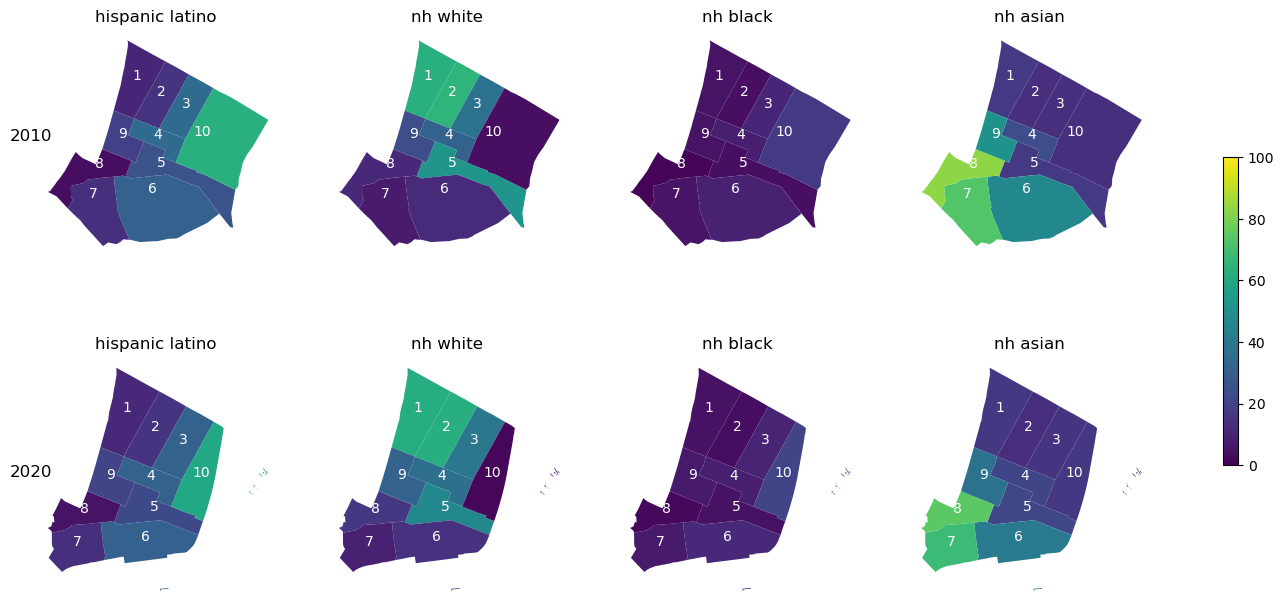

In [26]:
fig, axes = plt.subplots(2,4, figsize=(18, 8))

yrs = [2010, 2020]
for j in range(2):
    for i in range(len(race_cols_per)):
        cb3_gdf_sector[cb3_gdf_sector['year']==yrs[j]].plot(ax=axes[j,i], 
        column=race_cols_per[i], vmin=0, vmax=100, legend=False)
        axes[j,i].set_title(f'{race_cols_per[i].replace('_', ' ').replace('per','')}')
        #axes[j,i].set_axis_off()
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        axes[j,i].spines['top'].set_visible(False)
        axes[j,i].spines['right'].set_visible(False)
        axes[j,i].spines['bottom'].set_visible(False)
        axes[j,i].spines['left'].set_visible(False)
        for idx, row in cb3_gdf_diss.iterrows():
            axes[j,i].annotate(text=row['sectors'], xy=row['coords'],
                        horizontalalignment='center', color='white')
# assume it's the first (and only) mappable
patch_col = axes[0,0].collections[0]
cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)

for ax, row in zip(axes[:,0], [2010, 2020]):
    ax.set_ylabel(row, rotation=0, size='large')
plt.savefig('cb3_maps.pdf');

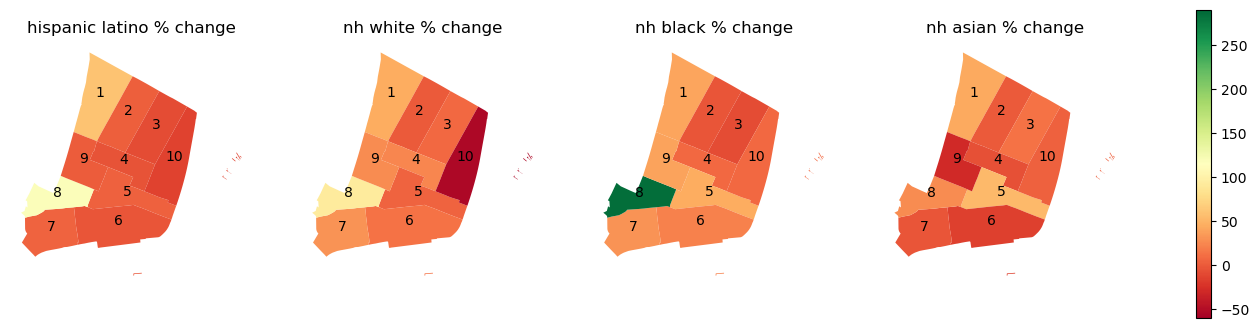

In [27]:
cb3_gdf_diss = cb3_gdf_diss.to_crs(2263)
fig, axes = plt.subplots(1,4, figsize=(18, 8))

race_cols = ['hispanic_latino', 'nh_white', 'nh_black', 'nh_asian']
for i in range(len(race_cols)):
    cb3_gdf_pct_change.plot(ax=axes[i], 
    column=race_cols[i], vmin=-60, vmax=290, legend=False, cmap='RdYlGn')
    #cb3_gdf_diss.plot(ax=axes[i], facecolor='none')
    for idx, row in cb3_gdf_diss.iterrows():
        axes[i].annotate(text=row['sectors'], xy=row['coords'],
                    horizontalalignment='center', color='black')
    axes[i].set_title(f'{race_cols_per[i].replace('_', ' ').replace('per','% change')}')
    axes[i].set_axis_off()
# assume it's the first (and only) mappable
patch_col = axes[0].collections[0]
cb = fig.colorbar(patch_col, ax=axes, shrink=0.5)
plt.savefig('cb3_maps_pct_change.pdf');

## ACS Data

In [28]:
# load acs dict
acs_dict = pd.read_excel('acs_dict.xlsx').set_index('colname').to_dict()['textname']

In [59]:
acs_dict_denom = pd.read_excel('acs_dict.xlsx').set_index('denom_col')
acs_dict_denom = acs_dict_denom[acs_dict_denom.index.notna()]
acs_dict_denom_dict = {u: acs_dict_denom.loc[u,'textname'].tolist() for u in acs_dict_denom.index.unique()}

In [80]:
acs_table = pd.read_excel('acs_dict.xlsx').set_index('table_name')
acs_table = acs_table[acs_table.index.notna()]
acs_table['pct_col'] = np.where(acs_table['denom_col'].notna(), acs_table['textname']+'_pct', '')
acs_dict_table = {u: acs_table.loc[u,'textname'].tolist() for u in acs_table.index.unique()}

acs_table_pct = acs_table.loc[acs_table['pct_col']!='']
acs_pct_dict_table = {u: acs_table_pct.loc[u,'pct_col'].tolist() for u in acs_table_pct.index.unique()}

In [30]:
acs_gdf = [pd.DataFrame(census.acs5.get(
    (
        tuple(['NAME', 'GEO_ID'] + list(acs_dict.keys()))
    ),
    geo={
        "for": f"tract:{','.join(cb3_tracts)}",
        "in": f"state:36 county:061",
    },
    year=yr,
)).assign(year = yr) for yr in [2020, 2023]]

In [31]:
acs_gdf_clean = pd.concat(acs_gdf).rename(columns=acs_dict)
acs_gdf_clean.head()

,NAME,GEO_ID,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,total_in_labor_force,total_hh_age,hh_gt65,hh_lt18,total_2person_hh,total_1person_hh,total_hh_size,total_3person_hh,total_4person_hh,year
0,"Census Tract 2.01, New York County, New York",1400000US36061000201,2761.0,1471.0,40.0,457.0,256.0,132.0,0.0,0.0,...,0.0,864.0,217.0,332.0,437.0,152.0,864.0,56.0,219.0,2020
1,"Census Tract 2.02, New York County, New York",1400000US36061000202,6908.0,3139.0,65.0,132.0,246.0,75.0,69.0,72.0,...,14.0,3216.0,1093.0,697.0,988.0,1442.0,3216.0,448.0,338.0,2020
2,"Census Tract 6, New York County, New York",1400000US36061000600,10628.0,5359.0,152.0,159.0,323.0,42.0,26.0,0.0,...,167.0,4470.0,2350.0,667.0,1317.0,1799.0,4470.0,762.0,592.0,2020
3,"Census Tract 8, New York County, New York",1400000US36061000800,9292.0,4725.0,136.0,190.0,176.0,48.0,19.0,67.0,...,101.0,4094.0,1593.0,630.0,1516.0,1399.0,4094.0,524.0,655.0,2020
4,"Census Tract 10.01, New York County, New York",1400000US36061001001,1437.0,856.0,40.0,50.0,38.0,9.0,30.0,0.0,...,10.0,785.0,304.0,146.0,200.0,425.0,785.0,73.0,87.0,2020


In [32]:
acs_gdf_clean['ct'] = acs_gdf_clean['GEO_ID'].str.slice(-6)
acs_gdf_clean['ct']

0     000201
1     000202
2     000600
3     000800
4     001001
       ...  
26    003602
27    003800
28    004001
29    004002
30    004200
Name: ct, Length: 62, dtype: object

In [33]:
cb3_acs_gdf = cb3_gdf_concat[cb3_gdf_concat['yr']==2020][['ct', 'sectors']].merge(acs_gdf_clean, on='ct', how='left')
cb3_acs_gdf.head()

,ct,sectors,NAME,GEO_ID,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,...,total_in_labor_force,total_hh_age,hh_gt65,hh_lt18,total_2person_hh,total_1person_hh,total_hh_size,total_3person_hh,total_4person_hh,year
0,001401,5,"Census Tract 14.01, New York County, New York",1400000US36061001401,2999.0,1326.0,38.0,106.0,71.0,21.0,...,0.0,1569.0,599.0,281.0,415.0,762.0,1569.0,247.0,145.0,2020
1,001401,5,Census Tract 14.01; New York County; New York,1400000US36061001401,3395.0,1857.0,88.0,96.0,31.0,8.0,...,0.0,1761.0,950.0,215.0,657.0,763.0,1761.0,195.0,146.0,2023
2,001402,5,"Census Tract 14.02, New York County, New York",1400000US36061001402,2693.0,1309.0,10.0,28.0,29.0,15.0,...,79.0,1476.0,561.0,134.0,400.0,807.0,1476.0,152.0,117.0,2020
3,001402,5,Census Tract 14.02; New York County; New York,1400000US36061001402,3449.0,1516.0,33.0,0.0,55.0,0.0,...,156.0,1807.0,652.0,281.0,639.0,833.0,1807.0,178.0,157.0,2023
4,001800,9,"Census Tract 18, New York County, New York",1400000US36061001800,7101.0,3727.0,100.0,18.0,113.0,64.0,...,139.0,3095.0,1013.0,362.0,879.0,1521.0,3095.0,397.0,298.0,2020


In [34]:
cb3_acs_gdf_bysector = cb3_acs_gdf.groupby(['sectors', 'year'])[list(acs_dict.values())].sum()
cb3_acs_gdf_total = cb3_acs_gdf.groupby(['year'])[list(acs_dict.values())].sum().reset_index()

In [35]:
cb3_acs_gdf_total['sectors'] = 'total'
cb3_acs_gdf_total = cb3_acs_gdf_total.set_index(['sectors', 'year'])

In [36]:
cb3_acs_gdf_bysector.head()

totalpop  totalpop_male  totalpop_male_u5  totalpop_male_5to9  \
sectors year                                                                  
1       2020   26711.0        13113.0             336.0               215.0   
        2023   26021.0        12965.0             358.0               247.0   
2       2020   17450.0         8853.0             327.0               101.0   
        2023   17178.0         8230.0             438.0                51.0   
3       2020   16137.0         7874.0             123.0               140.0   

              totalpop_male_10to14  totalpop_male_15to17  \
sectors year                                               
1       2020                  62.0                 107.0   
        2023                  86.0                 118.0   
2       2020                 204.0                 240.0   
        2023                  18.0                  73.0   
3       2020                 209.0                 141.0   

              totalpop_male_18to19  totalpop_male_20  totalpop_male_21  \
sectors year                                                             
1       2020                1514.0             499.0             190.0   
        2023                1471.0             450.0             225.0   
2       2020                  64.0              50.0              99.0   
        2023                  61.0               0.0              27.0   
3       2020                  29.0              43.0             111.0   

              totalpop_male_22to24  ...  foreign_born_total  \
sectors year                        ...                       
1       2020                 607.0  ...             26711.0   
        2023                 926.0  ...             26021.0   
2       2020                 345.0  ...             17450.0   
        2023                 315.0  ...             17178.0   
3       2020                 371.0  ...             16137.0   

              total_in_labor_force  total_hh_age  hh_gt65  hh_lt18  \
sectors year                                                         
1       2020                  20.0       11826.0   2225.0    644.0   
        2023                  13.0       11639.0   2580.0    788.0   
2       2020                   0.0        9923.0   2337.0    799.0   
        2023                   0.0       10328.0   2262.0    866.0   
3       2020                  30.0        7881.0   1680.0   1034.0   

              total_2person_hh  total_1person_hh  total_hh_size  \
sectors year                                                      
1       2020            3897.0            6434.0        11826.0   
        2023            3585.0            6447.0        11639.0   
2       2020            2918.0            5480.0         9923.0   
        2023            3201.0            5839.0        10328.0   
3       2020            2425.0            3963.0         7881.0   

              total_3person_hh  total_4person_hh  
sectors year                                      
1       2020             968.0             527.0  
        2023            1276.0             331.0  
2       2020            1179.0             346.0  
        2023             978.0             310.0  
3       2020             911.0             582.0  

[5 rows x 138 columns]

In [37]:
for col in acs_dict_denom_dict.keys():
    for num in acs_dict_denom_dict[col]:
        cb3_acs_gdf_bysector[num + '_pct'] = cb3_acs_gdf_bysector[num]/cb3_acs_gdf_bysector[col]
        cb3_acs_gdf_total[num + '_pct'] = cb3_acs_gdf_total[num]/cb3_acs_gdf_total[col]

/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_10675/269078120.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cb3_acs_gdf_bysector[num + '_pct'] = cb3_acs_gdf_bysector[num]/cb3_acs_gdf_bysector[col]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_10675/269078120.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cb3_acs_gdf_total[num + '_pct'] = cb3_acs_gdf_total[num]/cb3_acs_gdf_total[col]
/var/folders/_q/g5l2s5950hz1zr9syt43gzp80000gn/T/ipykernel_10675/269078120.py:3: PerformanceWarning: DataFrame 

In [38]:
cb3_acs_gdf_combined = pd.concat([cb3_acs_gdf_bysector, cb3_acs_gdf_total], axis=0).reset_index()
cb3_acs_gdf_combined.head()

,sectors,year,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,foreign_born_pct,foreign_born_total_pct,total_hh_age_pct,hh_gt65_pct,hh_lt18_pct,total_2person_hh_pct,total_1person_hh_pct,total_hh_size_pct,total_3person_hh_pct,total_4person_hh_pct
0,1,2020,26711.0,13113.0,336.0,215.0,62.0,107.0,1514.0,499.0,...,0.216540,1.0,1.0,0.188145,0.054456,0.329528,0.544055,1.0,0.081854,0.044563
1,1,2023,26021.0,12965.0,358.0,247.0,86.0,118.0,1471.0,450.0,...,0.231198,1.0,1.0,0.221669,0.067703,0.308016,0.553914,1.0,0.109631,0.028439
2,2,2020,17450.0,8853.0,327.0,101.0,204.0,240.0,64.0,50.0,...,0.186590,1.0,1.0,0.235513,0.080520,0.294064,0.552252,1.0,0.118815,0.034868
3,2,2023,17178.0,8230.0,438.0,51.0,18.0,73.0,61.0,0.0,...,0.191000,1.0,1.0,0.219016,0.083850,0.309934,0.565356,1.0,0.094694,0.030015
4,3,2020,16137.0,7874.0,123.0,140.0,209.0,141.0,29.0,43.0,...,0.270744,1.0,1.0,0.213171,0.131202,0.307702,0.502855,1.0,0.115594,0.073848


In [39]:
pct_cols = [x for x in cb3_acs_gdf_bysector.columns if '_pct' in x]
cb3_acs_gdf_long = cb3_acs_gdf_combined.melt(id_vars=['sectors', 'year'], 
value_vars=list(acs_dict.values()) + pct_cols).pivot(columns=['year'], 
index=['sectors', 'variable'], values='value')

cb3_acs_gdf_long['diff'] = cb3_acs_gdf_long[2023] - cb3_acs_gdf_long[2020]
cb3_acs_gdf_long['pct_change'] = (cb3_acs_gdf_long[2023] - cb3_acs_gdf_long[2020])/cb3_acs_gdf_long[2020]
cb3_acs_gdf_long = cb3_acs_gdf_long.reset_index().pivot(index=['variable'],
columns=['sectors'], values=[2020, 2023, 'diff', 'pct_change']).swaplevel(axis=1)\
    .sort_index(axis=1,level=[0,1],ascending=[True,True])

In [81]:
# write to excel
workbook = pd.ExcelWriter('acs_summary.xlsx', engine="xlsxwriter")

for col in acs_dict_table.keys():
    cb3_acs_gdf_long.loc[acs_dict_table[col]].reset_index().to_excel(workbook, sheet_name=col, index=True)

for col in acs_pct_dict_table.keys():
    cb3_acs_gdf_long.loc[acs_pct_dict_table[col]].reset_index().to_excel(workbook, sheet_name=col+'_pct', index=True)

#workbook.save()
workbook.close()